In [1]:
%pylab inline
import sympy as sym

Populating the interactive namespace from numpy and matplotlib


We'll need to compute

$$
A_{ij} := \int_a^b v_j' v_i' 
$$

and 

$$
f_i := \int_a^b v_i f
$$

We split the interval in $M$ elements (segments), with $M+1$ vertices (element boundaries). Define the element boundaries $q := [a, q_1, q_2, ..., q_{M-1}, b]$, and the elements sizes $h_k := v_{k+1}-q_k$. 
In $[a,b]$ we have a total of $N$ basis functions, which are piecewise polynomials of degree $d$, so that in each segment there are always at most $d+1$ non-zero basis functions, and $d+1$ support points.

We assume that each support point can be interpreted as the image of reference support points $\hat a_\alpha$, where $\alpha \in [0,d]$, throught the mapping $F_k(s) := q_k+h_k s$ which maps $[0,1]$ to $T_k := [q_k, q_{k+1}]$.


Similarly, every global basis function $v_j$ can be seen as the composition of a *reference* basis function $\hat v_\alpha$ defined on the reference interval $[0,1]$, and the inverse of the element transformation $F_k(s) := q_k+h_k s$ which maps $[0,1]$ to $[q_k, q_{k+1}]$, that is: 

$$
v_i(F_k(s)) = P_{ki\alpha} \hat v_\alpha(s)
$$

Where $P_{i\alpha}$ represents the numbering of the local basis function $\alpha \in [0,d]$, i.e., given the $(d+1)$ reference basis functions in $0,1$ of degree $d$, $P_{ki\alpha}$.

We will implement the numbering as a matrix $P \in R^{M,d+1}$, which returns the global index $i$, given the local element index $k$ and the local basis function index $i$, i.e., 


$$
v_{P_{k\alpha}}(F_k(s)) = \hat v_\alpha(s)
$$

Notice that, if we want to compute the derivative w.r.t. $x$ of $v_i$, computed in $F_k(s)$, as a function of the derivative of $\hat v_\alpha$ w.r.t. $s$, we need to take into account also the derivative of $F_k$, i.e., since $(v\circ F_k)' = (v' \circ F_k) F_k'$, we have


$$
v'_{P_{k\alpha}}(F_k(s)) = \hat v'_\alpha(s)/F'_k(s) = \hat v'_\alpha(s)/h_k
$$

In [2]:
# Let's define the domain discretisazion. In 1D, this is just a set of vertices, identifying edges
a = 0 
b = 1
M = 4 # Number of elements
degree = 3
# Make sure we don't choose degree = 0. This won't work. Piecewise constants cannot be continuous
assert degree > 0

# We now choose the number of quadrature points, in order to integrate *exactly* 
# both (v_i, v_j) and (v'_i, v'_j)
n_quadrature_points = 2*degree+1

# To get a continuous space, we construct piecewise polynomials with support points on the boundary of the
# elements. If the degree is greater than 1, then we pick (d-1) equispaced points in the interior of the
# elements as additional support points.

# Notice that the total number of degrees of freedom is equal to the number of vertices (M+1) plus the 
# number of *interior*  basis functions (d+1-2), that is: (M+1) + (d-1)*M = M*d+1
N = M*degree+1

ref_vertices = linspace(0,1,degree+1)

vertices = linspace(a,b,M+1) # Vertices of our triangulation

In [3]:
# The reference element is [0,1]. We construct the mappings, the determinant of their Jacobians, and the 
# reference Basis functions

def mapping(q, i):
    """
    Returns the mapping from [0,1] to T_k := [q[k], q[k+1]]
    """
    assert i < len(q)-1
    assert i >= 0
    return lambda x: q[i]+x*(q[i+1]-q[i])

def mapping_J(q,i):
    assert i < len(q)-1
    assert i >= 0
    return (q[i+1]-q[i])

def lagrange_basis(q, i):
    assert i < len(q)
    assert i >= 0
    return lambda x: prod([(x-q[j])/(q[i]-q[j]) for j in range(len(q)) if i!=j], axis=0)

# Workaround, to allow lambdify to work also on constant expressions
def np_lambdify(varname, func):
    lamb = sym.lambdify(varname, func, modules=['numpy'])
    if func.is_constant():
        return lambda t: full_like(t, lamb(t))
    else:
        return lambda t: lamb(np.array(t))

def lagrange_basis_derivative(q,i,order=1):
    t = sym.var('t')
    return np_lambdify(t, lagrange_basis(q,i)(t).diff(t,order))

In [4]:
# Let's check that, on each element, F_k(0) = q[k] and F_k(1) = q[k+1]
assert abs(array([mapping(vertices, i)(0) for i in range(M)]) - vertices[:-1]).max() < 1e-16
assert abs(array([mapping(vertices, i)(1) for i in range(M)]) - vertices[1:]).max() < 1e-16

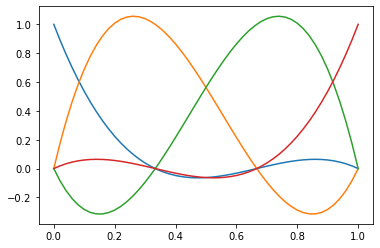

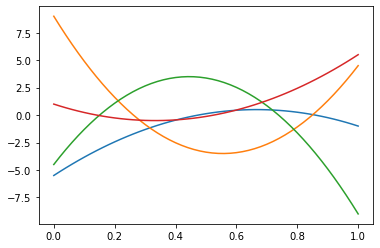

In [5]:
x = linspace(0,1,51)

V = array([lagrange_basis(ref_vertices,i)(x) for i in range(degree+1)]).T
Vp = array([lagrange_basis_derivative(ref_vertices,i)(x) for i in range(degree+1)]).T
_ = [plot(x, V)]
show()
_ = [plot(x, Vp)]
show()

In [6]:
# Now construct an interpolatory quadrature formula on [0,1]
q, w = numpy.polynomial.legendre.leggauss(n_quadrature_points)

q = (q+1)/2
w = w/2

In [7]:
# And build a global numbering of the basis functions i = P[k,alpha]. Keep in mind that, to ensure continuity, 
# we identify the global index the first basis function of each element, with the global index of the 
# last basis function of the previous element

P = zeros((M,degree+1), dtype=int)

for k in range(M):
    start = k*degree
    P[k] = array(range(start,start+degree+1))

assert P.max() == N-1
print(P)

[[ 0  1  2  3]
 [ 3  4  5  6]
 [ 6  7  8  9]
 [ 9 10 11 12]]


In [8]:
# Now we build, for each segment, the transformation of quadrature points and weights, so that we can 
# integrate the rhs and the matrices

Q = array([mapping(vertices,k)(q) for k in range(M)])
JxW = array([mapping_J(vertices,k)*w for k in range(M)])

In [9]:
# Let's test that everything works: the integral between 0 and 1 of the function f(x) = x should return 0.5. 
# Then sum_k q[k].dot(w_k) should be 0.5.

integral = 0
for k in range(M):
    integral = integral + Q[k].dot(JxW[k])

assert abs(integral - .5) < 1e-16

#same as
einsum('kq,kq', Q, JxW)

0.49999999999999994

In [10]:
# Construct the matrix B[k,j,i], defined as the value of v_i(F_k(x[j]))
B = zeros((M, len(x), N))

for k in range(M):
    B[k,:,P[k]] = V.T
    
# To evaluate functions and to do some plotting, also gather together all F_k(x[j]) in X[k,j]
X = array([mapping(vertices,k)(x) for k in range(M)])

In [11]:
X.shape, B.shape

((4, 51), (4, 51, 13))

In [12]:
# Reshaping X and B, we can use them to compute piecewise interpolation
X = X.flatten()
B = B.reshape((len(X),-1))

X.shape, B.shape

((204,), (204, 13))

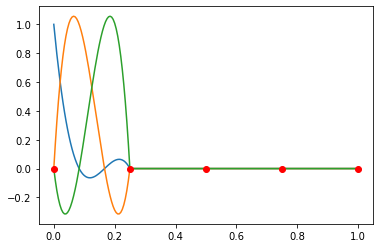

In [13]:
_ = plot(X, B[:,0:3]) 
_ = plot(vertices, 0*vertices,'ro')

In [14]:
# Notice that the global support points are the image through F_k of the reference support points,
# Numbered according to the matrix P, i.e..

support_points = zeros((N,))

for k in range(M):
    support_points[P[k]] = mapping(vertices,k)(ref_vertices)
    
# If we chose equispaced vertices, they should be identical to linspace(a,b,N):
abs(support_points - linspace(a,b,N)).max()

1.1102230246251565e-16

In [15]:
# Let's use the runge function as an example, and compute its *piecewise* polynomial interpolation 
def runge(x):
    return 1/(1+50*(x-.5)**2)

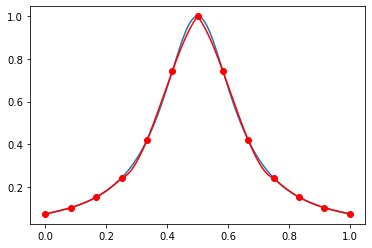

In [16]:
plot(X, runge(X))
plot(support_points, runge(support_points), 'ro')
plot(X, B.dot(runge(support_points)),'r')

In [17]:
# Construct a arrays Bq and Bprimeq: Bq[k,j,i] is v_i(T_k(q[j])), 
# and Bprimeq[k,j,i] is v'_i(T_k(q[j]))/T'_k(q[j])
Bq = zeros((M, n_quadrature_points, N))
Bprimeq = zeros((M, n_quadrature_points, N))

Vq = array([lagrange_basis(ref_vertices,i)(q) for i in range(degree+1)]).T
Vprimeq = array([lagrange_basis_derivative(ref_vertices,i)(q) for i in range(degree+1)]).T

for k in range(M):
    Bq[k,:,P[k]] = Vq.T
    Bprimeq[k,:,P[k]] = Vprimeq.T/mapping_J(vertices,k)

Xq = Q.flatten()
Bq = Bq.reshape((len(Xq),-1))
Bprimeq = Bprimeq.reshape((len(Xq),-1))
JxWq = JxW.flatten()

In [18]:
# Now compute the integrals for the mass and stiffness matrices
mass_matrix = einsum('qi,qj,q',Bq,Bq,JxWq)
stiffness_matrix = einsum('qi,qj,q',Bprimeq,Bprimeq,JxWq)

In [19]:
# Notice that the stiffness matrix is non-invertible (Pure neumann problem in H1 is not uniquely solvable)
# In fact we are not imposing the boundary conditions on the space, and we need to enforce them numerically
linalg.cond(stiffness_matrix)

7.89617984234469e+16

In [20]:
# We do the same thing we did in the finite difference case: eliminate the rows corresponding to the boundary 
# points, set the diagonal to 1, and set the rhs to the desired boundary condition
stiffness_matrix[0,:] = stiffness_matrix[-1,:] = 0
stiffness_matrix[0,0] = stiffness_matrix[-1,-1] = 1 

# Let's check now if the matrix is well conditioned
linalg.cond(stiffness_matrix)

250.25346068360452

In [21]:
# Now let's first compute an L2 projection of the runge function, and compare with the interpolation
mass_rhs = einsum('qi,q,q', Bq, runge(Xq), JxWq)
u_projection = linalg.solve(mass_matrix, mass_rhs)

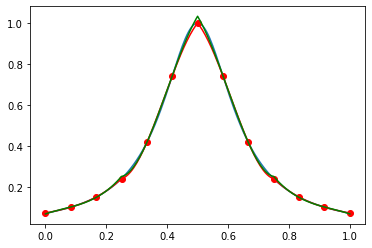

In [22]:
plot(X, runge(X))
u_interpolate = runge(support_points)
plot(support_points, u_interpolate, 'ro')
plot(X, B.dot(runge(support_points)),'r')
plot(X, B.dot(u_projection),'g')

In [23]:
# Finally, let's solve non trivial problem: -u'' = sin(2 pi x) with zero bc.

def rhs_function(x):
    return sin(2*pi*x)

def exact(x):
    return sin(2*pi*x)/(4*pi**2)

# Assemble the rhs, and make sure we set to zero the boundary conditions
rhs = einsum('qi,q,q', Bq, rhs_function(Xq), JxWq)
rhs[0] = rhs[-1] = 0

In [24]:
u = linalg.solve(stiffness_matrix, rhs)

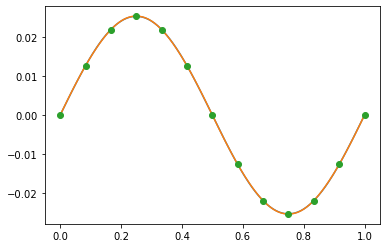

In [25]:
plot(X, exact(X))
plot(X, B.dot(u))
plot(support_points, exact(support_points), 'o')

In [26]:
# Let's compute also the L2 error: 
error = sqrt(einsum('q,q', (Bq.dot(u)-exact(Xq))**2, JxWq))
error

3.5160616773129974e-05